<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Quamtum_supremacy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

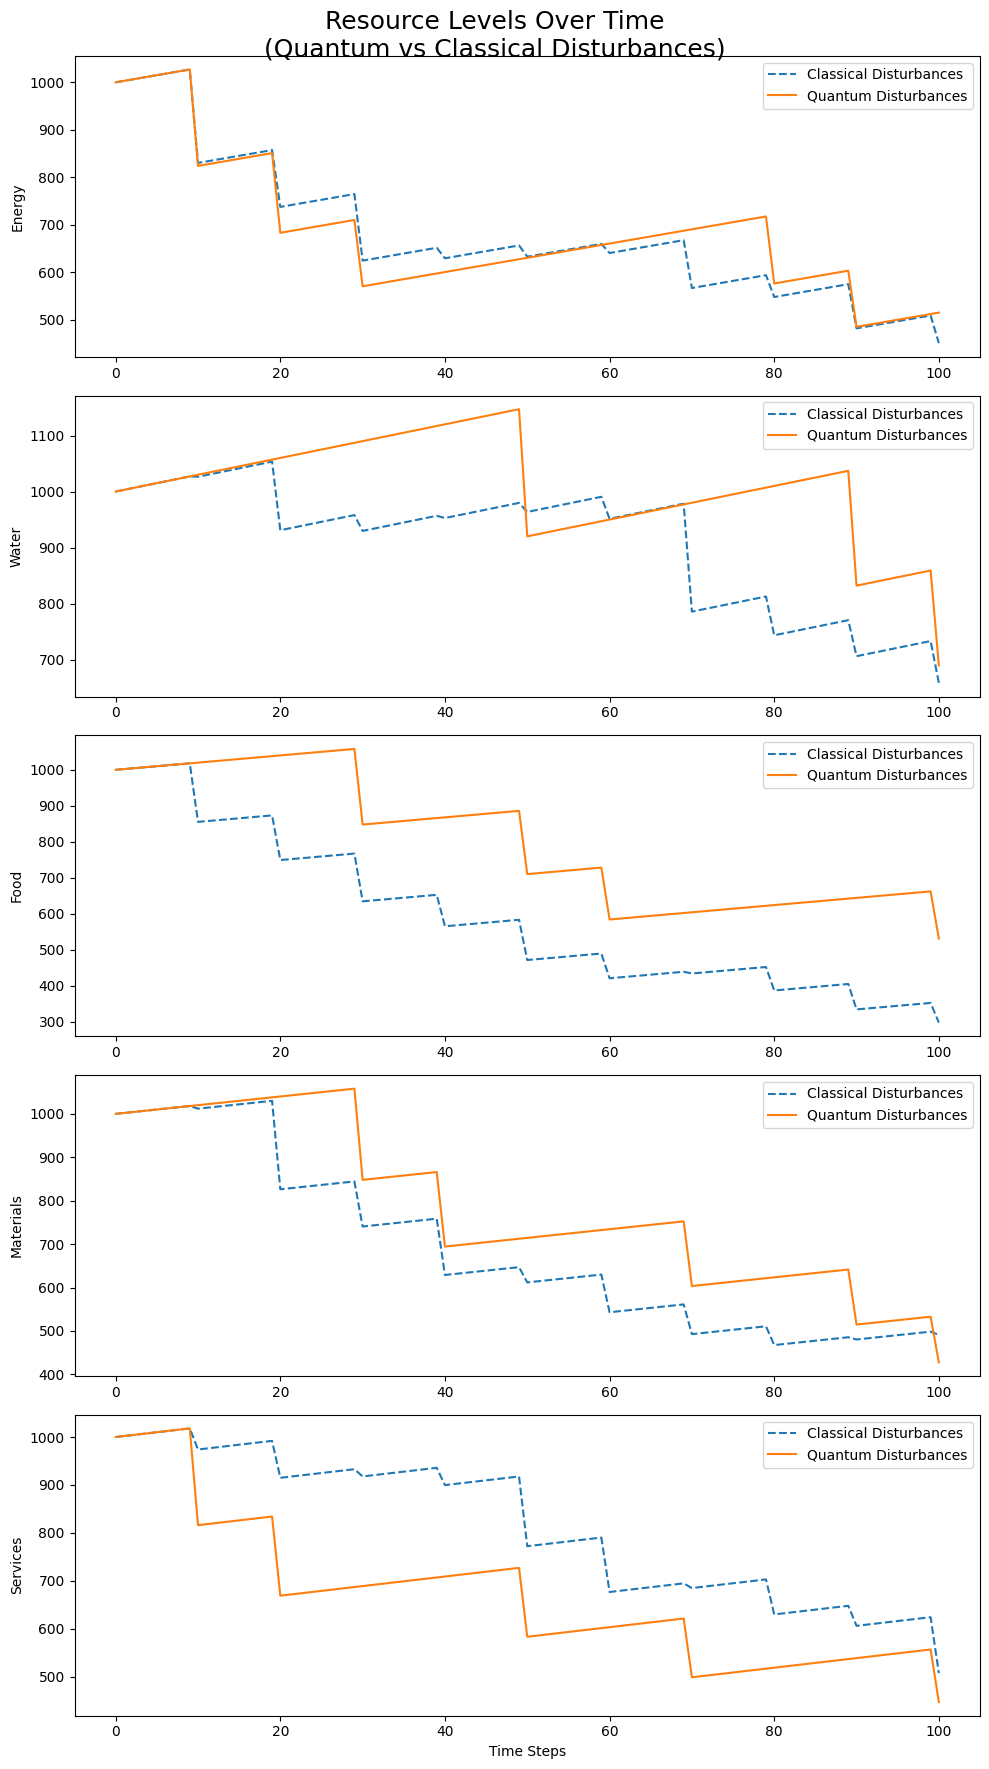

In [9]:
# Mars Quantum Economy Simulation (Corrected for Qiskit 2.0+)

# Install needed packages if you don't have them already
# !pip install qiskit qiskit-aer

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# -- Parameters --
num_steps = 100               # Simulation steps
quantum_injection_interval = 10  # Inject quantum disturbance every N steps
initial_resources = {
    'Energy': 1000,
    'Water': 1000,
    'Food': 1000,
    'Materials': 1000,
    'Services': 1000
}

# Resource dynamics (production/consumption per timestep)
production_rates = {
    'Energy': 10,
    'Water': 8,
    'Food': 6,
    'Materials': 5,
    'Services': 4
}

consumption_rates = {
    'Energy': 7,
    'Water': 5,
    'Food': 4,
    'Materials': 3,
    'Services': 2
}

# Shock strength scale
shock_strength = 0.2  # 20% resource drop max

# -- Helper Functions --

def generate_classical_shock():
    # Random shock independently for each resource
    return {k: np.random.uniform(-shock_strength, 0) for k in initial_resources.keys()}

def generate_quantum_shock():
    qc = QuantumCircuit(5, 5)  # Now create 5 classical bits too
    qc.h(range(5))
    qc.barrier()
    for _ in range(3):
        control, target = np.random.choice(5, size=2, replace=False)
        qc.cx(control, target)
        qc.h(np.random.randint(0,5))

    # Add measurements
    qc.measure(range(5), range(5))

    simulator = AerSimulator()
    job = simulator.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    bitstring = list(counts.keys())[0]

    shock = {}
    for idx, key in enumerate(initial_resources.keys()):
        shock[key] = -shock_strength if bitstring[4-idx] == '1' else 0
    return shock

# -- Simulation Core --

def simulate_economy(use_quantum=False):
    resources = initial_resources.copy()
    history = {k: [v] for k,v in resources.items()}

    for t in range(1, num_steps+1):
        # Produce and consume
        for key in resources.keys():
            resources[key] += production_rates[key] - consumption_rates[key]

        # Inject disturbances
        if t % quantum_injection_interval == 0:
            if use_quantum:
                shock = generate_quantum_shock()
            else:
                shock = generate_classical_shock()
            for key in resources.keys():
                resources[key] += shock[key] * resources[key]
                resources[key] = max(resources[key], 0)  # no negative resources

        # Record history
        for key in resources.keys():
            history[key].append(resources[key])

    return history

# -- Run simulations --

history_classical = simulate_economy(use_quantum=False)
history_quantum = simulate_economy(use_quantum=True)

# -- Plot Results --

fig, axs = plt.subplots(5, 1, figsize=(10, 18))
fig.suptitle('Resource Levels Over Time\n(Quantum vs Classical Disturbances)', fontsize=18)

for idx, key in enumerate(initial_resources.keys()):
    axs[idx].plot(history_classical[key], label='Classical Disturbances', linestyle='--')
    axs[idx].plot(history_quantum[key], label='Quantum Disturbances')
    axs[idx].set_ylabel(key)
    axs[idx].legend()

axs[-1].set_xlabel('Time Steps')
plt.tight_layout()
plt.show()
